In [1]:
import os
import pandas as pd
import numpy as np
import chardet # for encoding detection

import pycountry # country iso converter
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline
style.use("fivethirtyeight")

## DataViz
### ASK

In [2]:
with open("Data/rank_ask.csv", encoding='UTF-16') as f:
    contents = f.readlines()

column_names = contents[0].replace("\n", "").split("\t")
column_names = [i.replace(" ", "_").lower() for i in column_names]
rank = pd.DataFrame()

for row in contents[1:]:
    entry = pd.DataFrame(row.replace("\n", "").split("\t")).transpose()
    rank = pd.concat([rank, entry], axis=0)

rank.columns = column_names

In [3]:
def transform_date(data: pd.DataFrame, date_col: str):
    data[date_col] = pd.to_datetime(data[date_col])
    data["week"] = data[date_col].dt.isocalendar().week
    data["year"] = data[date_col].dt.isocalendar().year
    data["weekday"] = data[date_col].dt.isocalendar().day

transform_date(rank, "day_of_date")

In [4]:
for col in ["ask_wow_change", "ask_yoy_change", "av_seat_km_7days"]:
    rank[col] = [i.replace("%", "").replace(",", "") if len(
        i) != 0 else np.NaN for i in rank[col]]
    rank[col] = rank[col].astype(float)

rank.head(5)

,day_of_date,destination_country,ask_wow_change,ask_yoy_change,av_seat_km_7days,week,year,weekday
0,2020-01-01,Fiji,-23.69,-27.24,7.046698e+07,1,2020,3
0,2020-01-01,Kiribati,22.65,16.41,2.051441e+06,1,2020,3
0,2020-01-01,Marshall Islands (the),30.52,24.97,3.242602e+06,1,2020,3
0,2020-01-01,Micronesia (Federated States of),-7.66,-47.15,1.338898e+06,1,2020,3
0,2020-01-01,Nauru,206.25,-42.39,1.299758e+06,1,2020,3


In [5]:
countries = rank["destination_country"].unique().tolist()

In [6]:
def plot_country_sit(data, country_name, variable):

    country = data[data.destination_country == str(
        country_name)].reset_index().drop("index", axis=1)

    # Convert the country to the categorical
    country["year"] = pd.Categorical(country["year"])

    sns.set_theme(style="whitegrid")
    plot = sns.lineplot(data=country, x="week", y=str(variable), hue="year", palette="tab10", ci=None)
    plt.title(str(country_name) + "'s " + str(variable))
    plt.xticks(rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()
    plot.figure.savefig("Viz/" + str(country_name).replace(" ", "") + "_" + str(variable) + ".png", dpi=400)

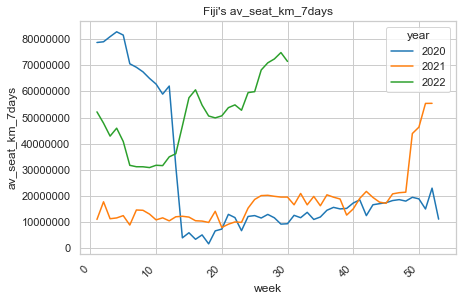

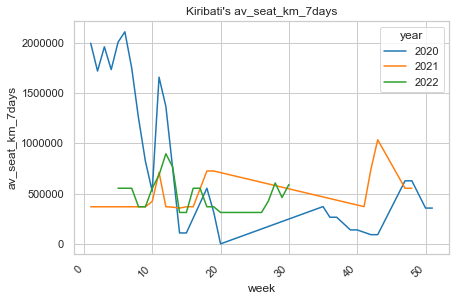

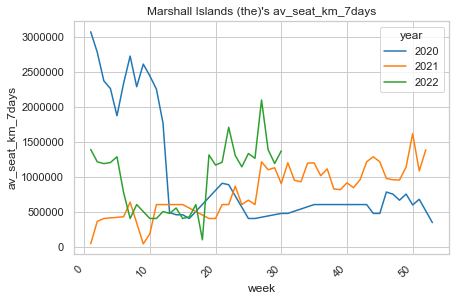

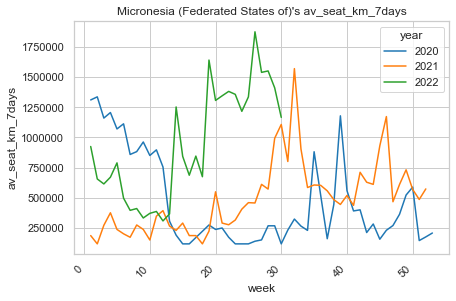

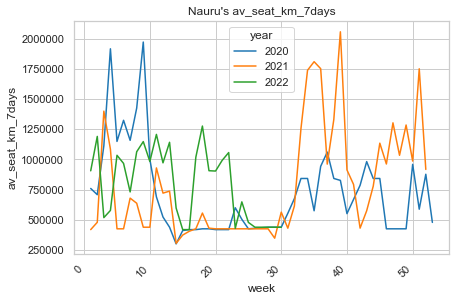

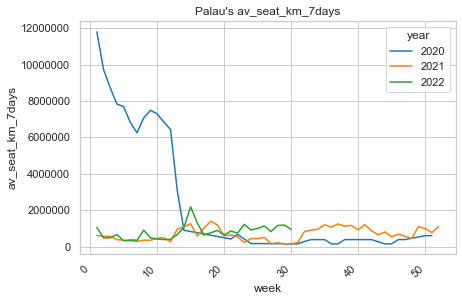

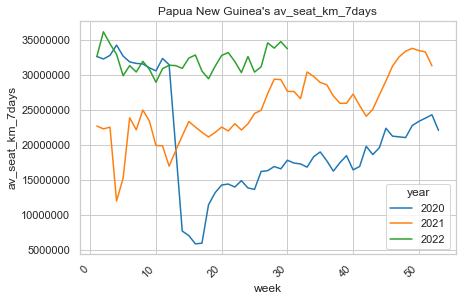

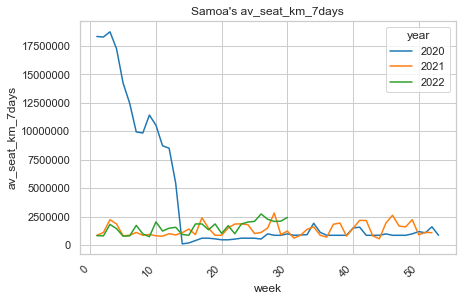

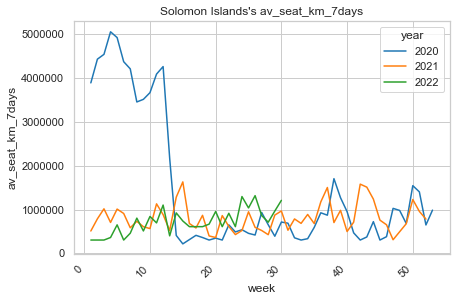

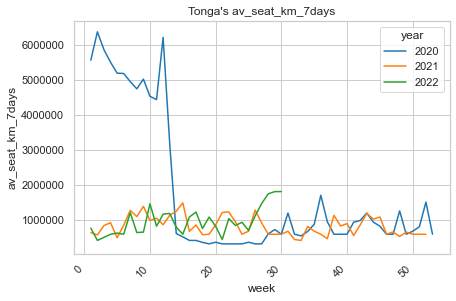

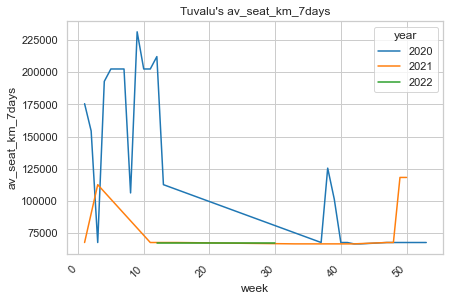

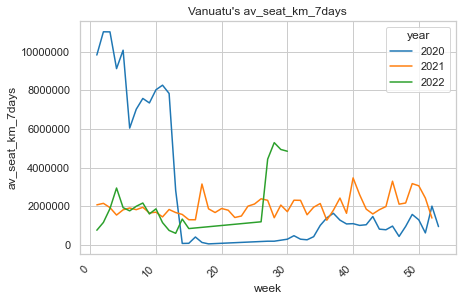

In [7]:
for i in countries:
    plot_country_sit(rank, i, "av_seat_km_7days")

### Passenger

In [8]:
psg = (pd.read_csv("Data/rank_psg_data.csv")
       .rename({"Day of date": "date"}, axis=1))
psg.head(5)

,destination_iso_country,date,psg_ranking,psg_wow_change,psg_yoy_change,destination_country,passengers_number_7days
0,WS,"January 1, 2020",4,-14.46%,0.26%,Samoa,6146
1,VU,"January 1, 2020",3,-8.16%,7.50%,Vanuatu,7566
2,TV,"January 1, 2020",12,0.00%,0.00%,Tuvalu,128
3,TO,"January 1, 2020",6,-45.49%,-25.76%,Tonga,2530
4,SB,"January 1, 2020",7,-14.83%,-17.17%,Solomon Islands,2268


In [9]:
transform_date(psg, "date")
psg["year"] = psg["year"].astype("category")

In [13]:
psg[psg.destination_country == "Fiji"][["destination_iso_country", "date", "passengers_number_7days"]].head(10)

,destination_iso_country,date,passengers_number_7days
11,FJ,2020-01-01,26874
23,FJ,2020-01-02,28362
35,FJ,2020-01-03,32109
47,FJ,2020-01-04,34138
58,FJ,2020-01-05,33496
69,FJ,2020-01-06,32191
80,FJ,2020-01-07,31661
91,FJ,2020-01-08,30471
103,FJ,2020-01-09,29554
115,FJ,2020-01-10,29672


In [10]:
def plot_countries_stat(data, x, y, yaxis: str, category: str, name: str):

    g = sns.relplot(
        data=data,
        x=x, y=y,
        col=category, style="year",
        kind="line", linewidth=2, zorder=5, ci=None,
        col_wrap=2, height=4, aspect=1.5, legend=False,
        facet_kws={'sharey': False, 'sharex': True}
    )

    for country, ax in g.axes_dict.items():
        ax.text(.4, .95, country, transform=ax.transAxes, fontweight="bold")

        sns.lineplot(
            data=data, x=x, y=y, units=category, style="year",
            estimator=None, color=".9", linewidth=1, ci=None, ax=ax,
        )
        ax.set_xticks(ax.get_xticks()[::2])

    g.set_titles("")
    g.set_axis_labels("", str(yaxis))
    g.tight_layout()
    g.savefig("Viz/"+str(name), dpi=400)

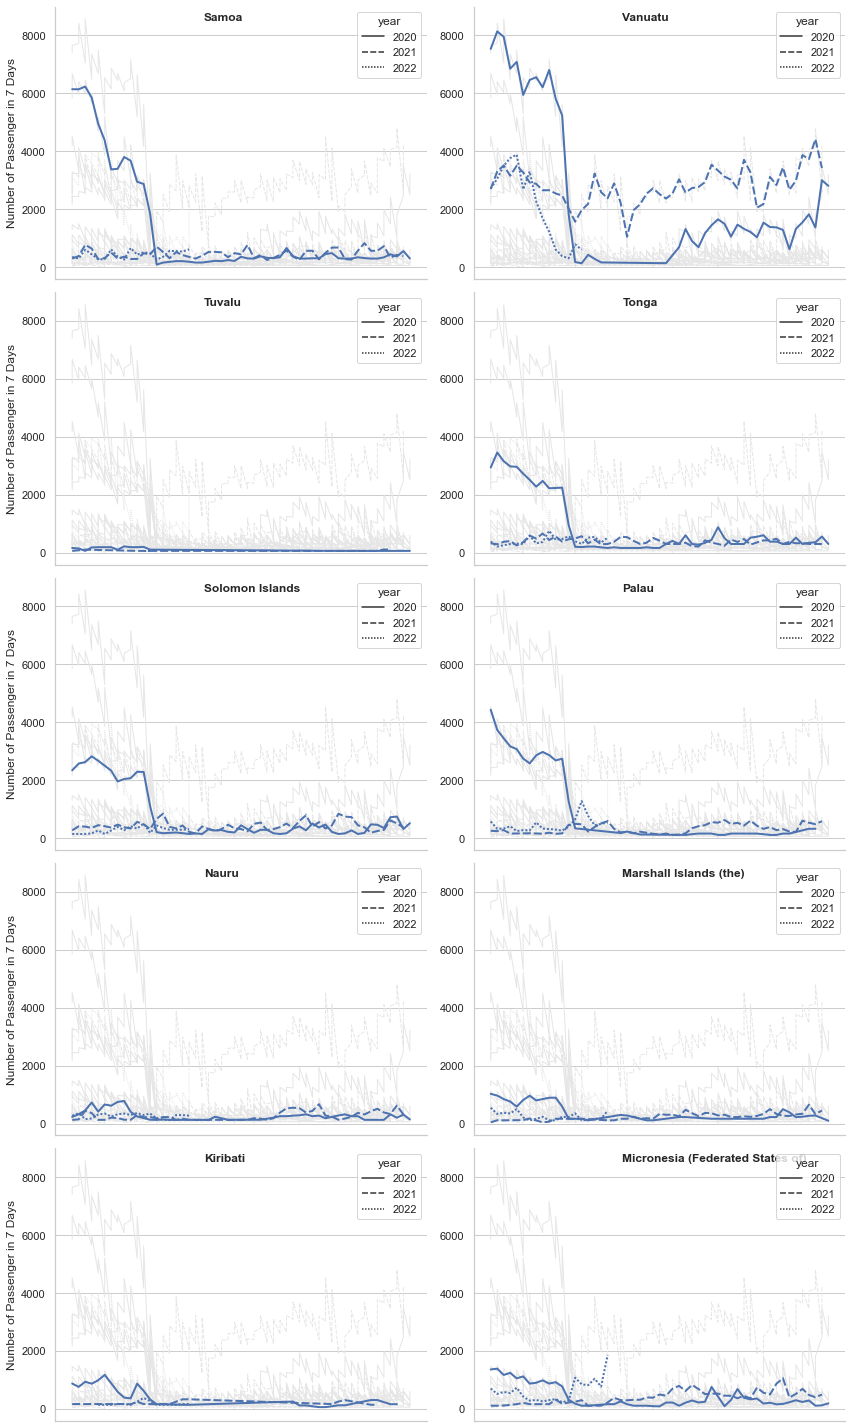

In [11]:
plot_countries_stat(data=psg[(psg.destination_country != "Fiji") & (psg.destination_country != "Papua New Guinea")],
                    x="week", y="passengers_number_7days", yaxis="Number of Passenger in 7 Days",
                    category="destination_country", name="NumPsgsIn7Days_wo")

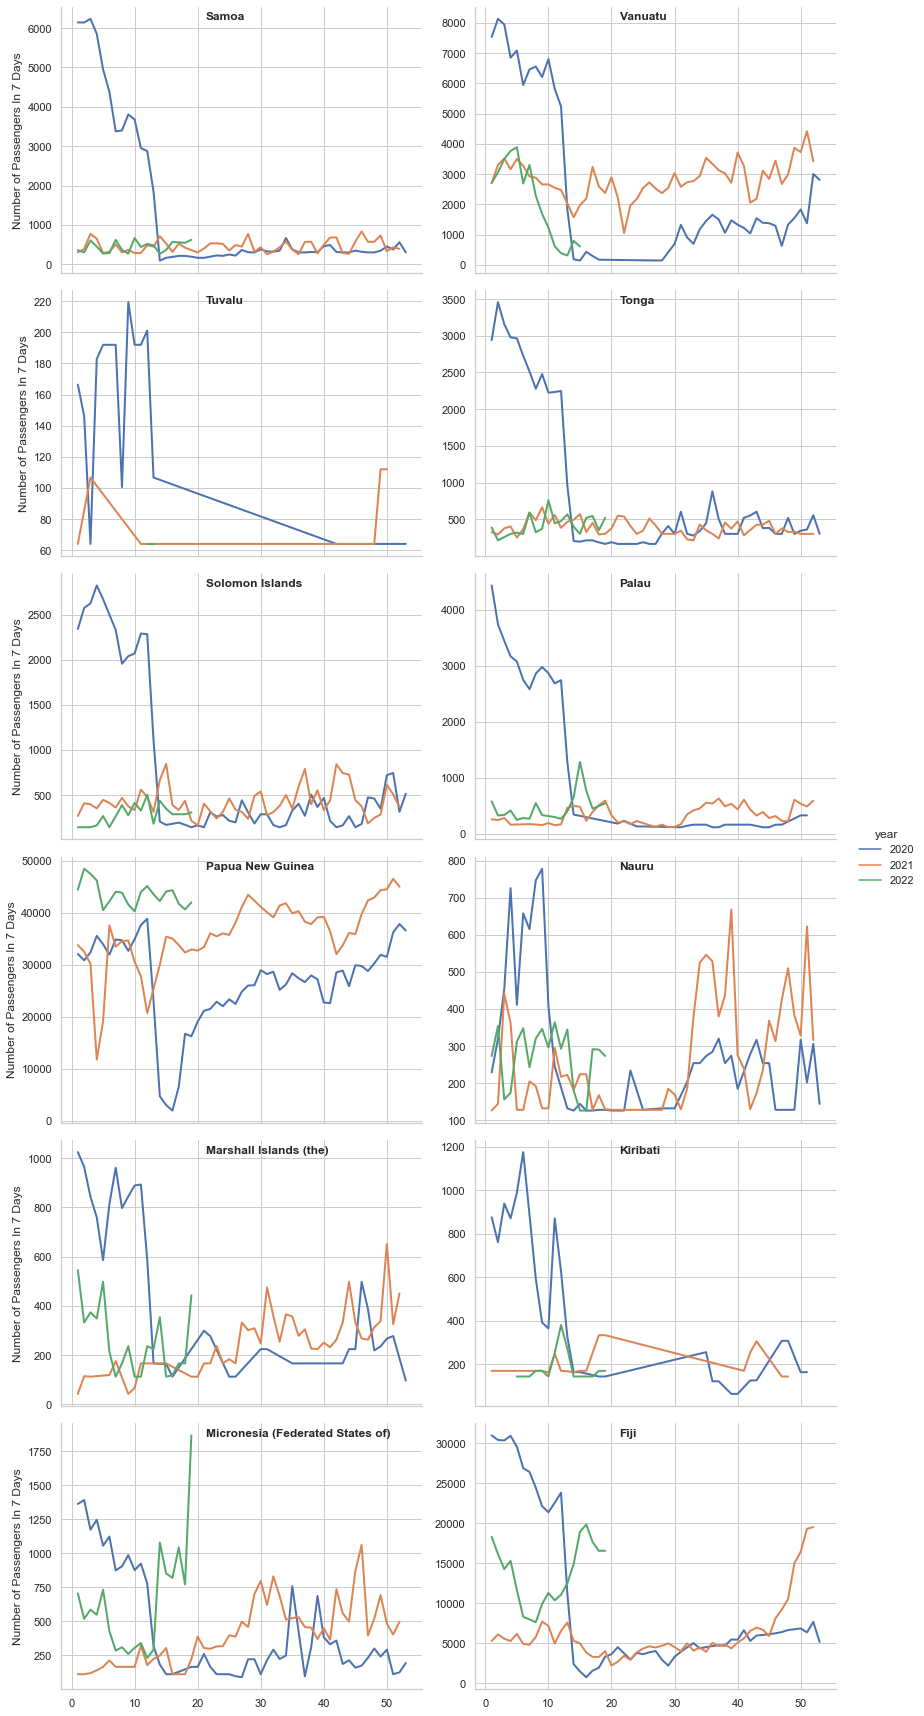

In [12]:
g = sns.relplot(
    data=psg,
    x="week", y="passengers_number_7days",
    col="destination_country", hue="year",
    kind="line", linewidth=2, zorder=5, ci=None,
    col_wrap=2, height=4, aspect=1.5, legend=True,
    facet_kws={'sharey': False, 'sharex': True}
)


for country, ax in g.axes_dict.items():
    ax.text(.4, .95, country, transform=ax.transAxes, fontweight="bold")

g.set_titles("")
g.set_axis_labels("", str("Number of Passengers In 7 Days"))
g.tight_layout()
g.savefig("Viz/NumberPsgIn7Days_freescale", dpi=400)

### Bokeh

In [13]:
def create_viz_df(data: pd.DataFrame,
                  voi: str):

    viz_df = pd.DataFrame()
    for country in countries:
        country_df = (data[data.destination_country == str(country)]
                      [["date", voi]]
                      .reset_index().drop("index", axis=1))
        country_df.columns = ["date", str(country)]
        if viz_df.empty == True:
            viz_df = pd.concat([viz_df, country_df], axis=1)
        else:
            viz_df = pd.concat([viz_df, country_df[str(country)]], axis=1)

    return viz_df

In [14]:
psg_viz = create_viz_df(psg, "passengers_number_7days")
psg_viz.head(5)

,date,Fiji,Kiribati,Marshall Islands (the),Micronesia (Federated States of),Nauru,Palau,Papua New Guinea,Samoa,Solomon Islands,Tonga,Tuvalu,Vanuatu
0,2020-01-01,26874,948.0,1130.0,1383.0,392.0,4183.0,33124,6146.0,2268.0,2530.0,128.0,7566.0
1,2020-01-02,28362,948.0,998.0,1329.0,260.0,4454.0,32506,5851.0,2274.0,2849.0,128.0,7406.0
2,2020-01-03,32109,816.0,944.0,1329.0,132.0,4524.0,32039,5897.0,2274.0,3142.0,192.0,7522.0
3,2020-01-04,34138,816.0,944.0,1469.0,132.0,4475.0,31514,6679.0,2444.0,2936.0,192.0,7650.0
4,2020-01-05,33496,853.0,1110.0,1303.0,128.0,4524.0,31114,6155.0,2444.0,3246.0,192.0,7538.0


In [15]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Legend

output_file('Viz/psg_daily.html')
p = figure(height=600, width=1000,
           title="Number of Passengers in 7 Days By Country",
           x_axis_type="datetime",
           x_axis_label="Date",
           y_axis_label="Number of Passengers Per Day",
           tooltips=[("Country", "$name"),
                     ("Passenger in 7 Days", "@$name")])
p.add_layout(Legend(), 'right')
source = ColumnDataSource(psg_viz)

for country, color in zip(countries, Category20[12]):
    # have to use different colnames for y-coords so tooltip can refer to @$name
    p.line('date', country, source=source, name=country,
           legend_label=country, color=color)

p.legend.label_text_font_size = '9pt'
p.legend.click_policy = "mute"
p.legend.location = "top_left"


show(p)

### Flight

In [16]:
fl = (pd.read_csv("Data/rank_fl_data.csv")
       .rename({"Day of date": "date"}, axis=1))
transform_date(fl, "date")

In [17]:
fl.head(5)

,destination_iso_country,date,fl_ranking,fl_wow_change,fl_yoy_change,destination_country,flights_number_7days,week,year,weekday
0,WS,2020-01-01,5,-7.32%,18.75%,Samoa,38,1,2020,3
1,VU,2020-01-01,3,-13.25%,5.88%,Vanuatu,72,1,2020,3
2,TV,2020-01-01,12,0.00%,0.00%,Tuvalu,2,1,2020,3
3,TO,2020-01-01,4,-18.00%,0.00%,Tonga,41,1,2020,3
4,SB,2020-01-01,7,-15.00%,-19.05%,Solomon Islands,17,1,2020,3


In [18]:
png = fl[fl.destination_country == "Papua New Guinea"].reset_index().drop("index", axis=1)

wow_change_manual = list()
for i in range(0, len(png)):
    if (i < 7):
        wow_change_manual.append(np.NaN)
    else:
        last_wday_number = png["flights_number_7days"][i-7]
        wday_number = png["flights_number_7days"][i]
        wow_ratio = (wday_number - last_wday_number)/last_wday_number
        wow_change_manual.append(round(wow_ratio*100, 2))

png["wow_change_manual"] = wow_change_manual

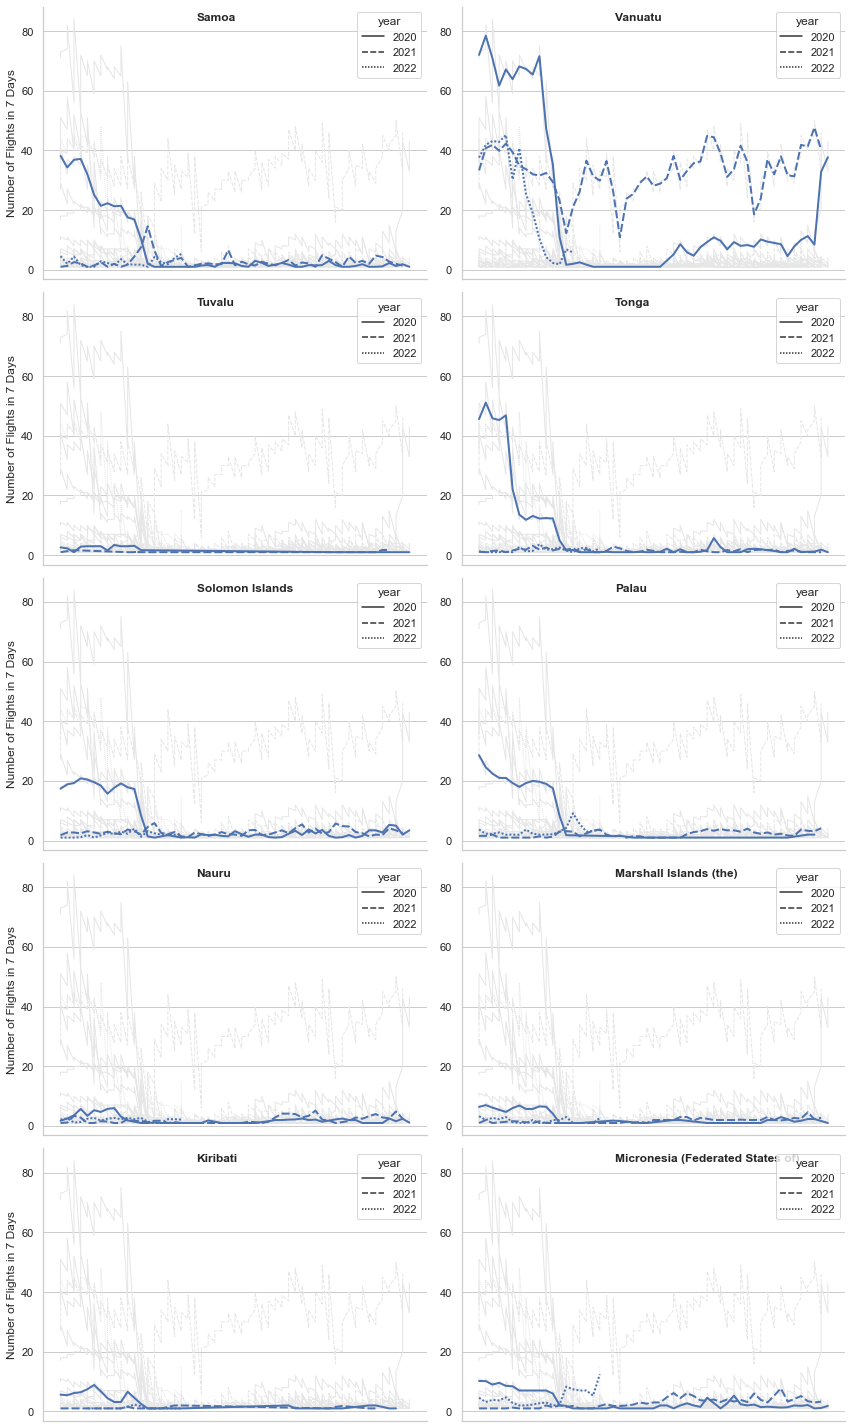

In [18]:
plot_countries_stat(data=fl[(fl.destination_country != "Fiji") & (fl.destination_country != "Papua New Guinea")],
                    x="week", y="flights_number_7days", yaxis="Number of Flights in 7 Days",
                    category="destination_country", name="NumFlsIn7Days")

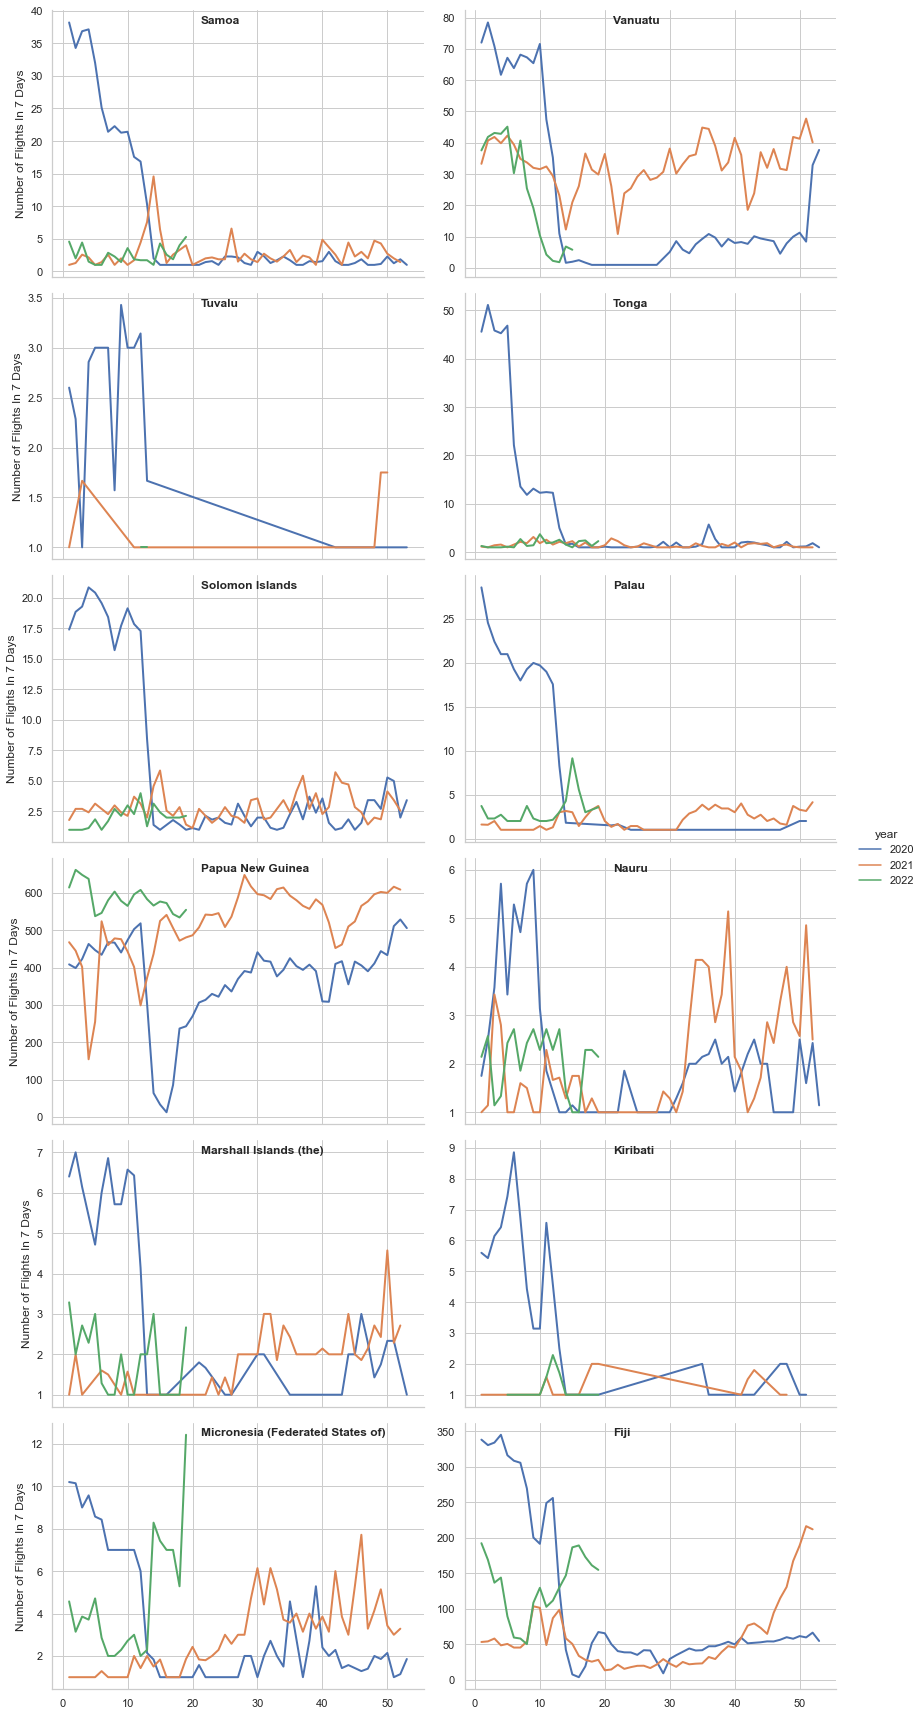

In [19]:
fl["year"] = fl["year"].astype("category")

g = sns.relplot(
    data=fl,
    x="week", y="flights_number_7days",
    col="destination_country", hue="year",
    kind="line", linewidth=2, zorder=5, ci=None,
    col_wrap=2, height=4, aspect=1.5, legend=True,
    facet_kws={'sharey': False, 'sharex': True}
)

for country, ax in g.axes_dict.items():
    ax.text(.4, .95, country, transform=ax.transAxes, fontweight="bold")

g.set_titles("")
g.set_axis_labels("", str("Number of Flights In 7 Days"))
g.tight_layout()
g.savefig("Viz/NumberFlsIn7Days_freescale", dpi=400)

In [20]:
fl_viz = create_viz_df(fl, "flights_number_7days")
output_file('Viz/fl.html')

p2 = figure(height=600, width=1000,
           title="Number of Flights in 7 Days By Country",
           x_axis_type="datetime",
           x_axis_label="Date",
           y_axis_label="Number of Flights in 7 Days",
           tooltips=[("Country", "$name"),
                     ("Passenger in 7 Days", "@$name")])
p2.add_layout(Legend(), 'right')
source = ColumnDataSource(fl_viz)

for country, color in zip(countries, Category20[12]):
    # have to use different colnames for y-coords so tooltip can refer to @$name
    p2.line('date', country, source=source, name=country,
           legend_label=country, color=color)

p2.legend.label_text_font_size = '9pt'
p2.legend.click_policy = "mute"
p2.legend.location = "top_left"

show(p2)

## Statistical Properties

In [21]:
psgfl = fl.merge(psg, on=["date", "weekday", "week", "year",
                 "destination_iso_country", "destination_country"])
psgfl["year"] = psgfl["year"].astype(int)

for country in countries:
    df = psgfl[psgfl.destination_country == str(country)].reset_index().drop([
        "index"], axis=1)
    df.to_csv("Data/" + str(country).replace(" ", "") + ".csv", encoding="utf-8")

In [22]:
psgfl.head(5)

,destination_iso_country,date,fl_ranking,fl_wow_change,fl_yoy_change,destination_country,flights_number_7days,week,year,weekday,psg_ranking,psg_wow_change,psg_yoy_change,passengers_number_7days
0,WS,2020-01-01,5,-7.32%,18.75%,Samoa,38,1,2020,3,4,-14.46%,0.26%,6146
1,VU,2020-01-01,3,-13.25%,5.88%,Vanuatu,72,1,2020,3,3,-8.16%,7.50%,7566
2,TV,2020-01-01,12,0.00%,0.00%,Tuvalu,2,1,2020,3,12,0.00%,0.00%,128
3,TO,2020-01-01,4,-18.00%,0.00%,Tonga,41,1,2020,3,6,-45.49%,-25.76%,2530
4,SB,2020-01-01,7,-15.00%,-19.05%,Solomon Islands,17,1,2020,3,7,-14.83%,-17.17%,2268


In [23]:
psgfl_stats = (psgfl[["destination_country", "date", "passengers_number_7days", "flights_number_7days"]]
               .groupby(["destination_country"])
               .describe())
psgfl_stats

passengers_number_7days                \
                                                   count          mean   
destination_country                                                      
Fiji                                               866.0   8733.728637   
Kiribati                                           294.0    355.078231   
Marshall Islands (the)                             586.0    333.529010   
Micronesia (Federated States of)                   736.0    485.635870   
Nauru                                              668.0    282.841317   
Palau                                              625.0    714.092800   
Papua New Guinea                                   866.0  33044.654734   
Samoa                                              829.0    819.884198   
Solomon Islands                                    843.0    560.066429   
Tonga                                              822.0    610.554745   
Tuvalu                                             144.0    130.222222   
Vanuatu                                            756.0   2703.302910   

                                                                          \
                                          std     min       25%      50%   
destination_country                                                        
Fiji                              7281.752791   372.0   4304.50   5638.5   
Kiribati                           304.937711    64.0    164.00    170.0   
Marshall Islands (the)             241.549273    19.0    166.00    278.0   
Micronesia (Federated States of)   355.712887    90.0    222.00    396.0   
Nauru                              174.464076   126.0    128.00    254.0   
Palau                              961.752699    90.0    166.00    326.0   
Papua New Guinea                  9429.835772  1821.0  28042.75  34403.0   
Samoa                             1289.160930    19.0    302.00    340.0   
Solomon Islands                    634.020565    73.0    270.00    314.0   
Tonga                              724.517282    64.0    302.00    302.0   
Tuvalu                              61.681388    64.0     64.00    128.0   
Vanuatu                           1746.322226    64.0   1466.00   2570.0   

                                                    flights_number_7days  \
                                       75%      max                count   
destination_country                                                        
Fiji                              10528.50  34138.0                866.0   
Kiribati                            443.50   1338.0                294.0   
Marshall Islands (the)              390.00   1152.0                586.0   
Micronesia (Federated States of)    674.00   2286.0                736.0   
Nauru                               384.00    914.0                668.0   
Palau                               596.00   4524.0                625.0   
Papua New Guinea                  40069.25  49065.0                866.0   
Samoa                               604.00   6679.0                829.0   
Solomon Islands                     532.00   3028.0                843.0   
Tonga                               553.00   3899.0                822.0   
Tuvalu                              192.00    256.0                144.0   
Vanuatu                            3270.00   8564.0                756.0   

                                                                              \
                                        mean         std   min    25%    50%   
destination_country                                                            
Fiji                               87.302540   81.678707   3.0   37.0   54.0   
Kiribati                            2.489796    2.266742   1.0    1.0    1.0   
Marshall Islands (the)              2.411263    1.653737   1.0    1.0    2.0   
Micronesia (Federated States of)    3.574728    2.586172   1.0    2.0    3.0   
Nauru                               2.193114    1.352486   1.0    1.0    2.0   


### Missing Data 

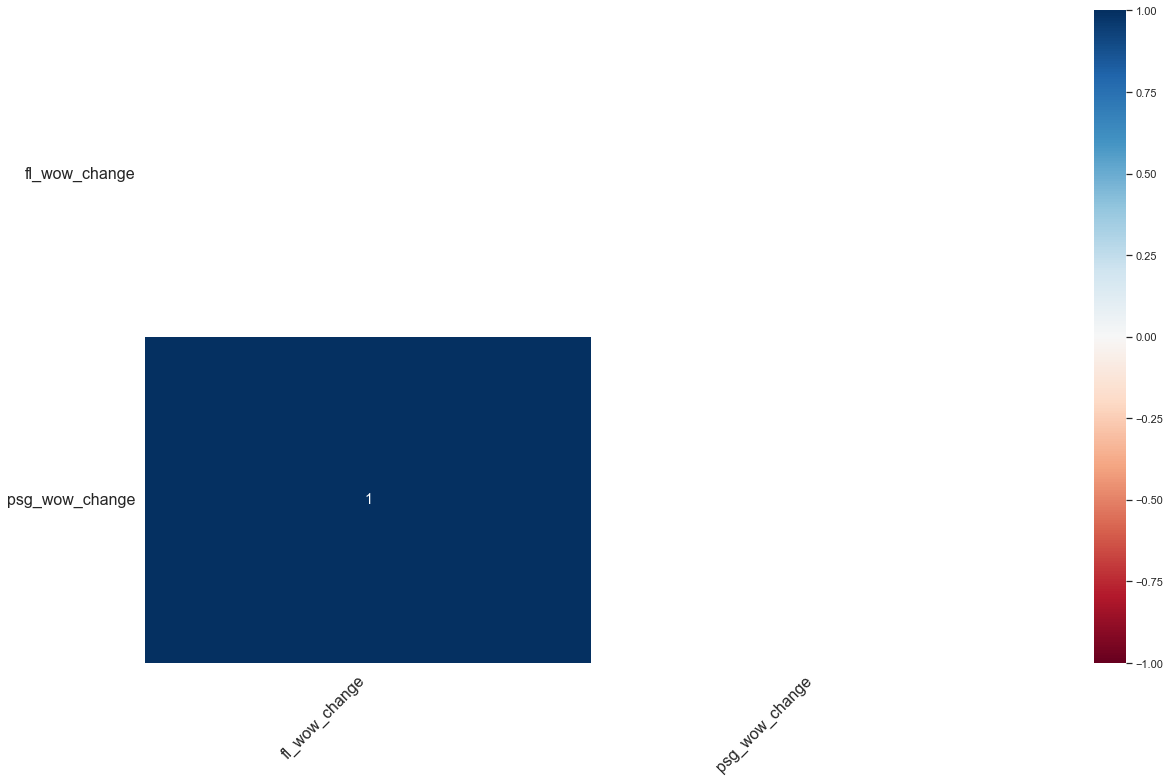

In [24]:
import missingno as msno
fig = msno.heatmap(psgfl)
fig.get_figure().savefig('Viz/ms_heatmap.png',dpi=400) 

In [25]:
missing = (psgfl[psgfl.fl_wow_change.isna() == True][["destination_country", "date"]]
           .reset_index().drop("index", axis=1))

missing.groupby(by="destination_country").count()

,date
destination_country,
Kiribati,150
Marshall Islands (the),126
Micronesia (Federated States of),105
Nauru,166
Palau,101
Samoa,32
Solomon Islands,20
Tonga,41
Tuvalu,51


In [26]:
missing_count = missing.groupby(by="destination_country").count().reset_index()
missing_count.columns = ["destination_country", "missing"]

date_range, length = list(), list()
for country in countries:
    country_df = fl[fl.destination_country ==
                    country].reset_index().drop("index", axis=1)
    date_delta = country_df.iloc[-1]["date"] - country_df["date"][0]
    if country == "Papua New Guinea" or country == "Fiji":
        pass
    else:
        date_range.append(int(date_delta.days))
        length.append(len(country_df))

missing_count["df_length"], missing_count["date_range"] = length, date_range
missing_count["available"] = missing_count["df_length"] - \
    missing_count["missing"]
missing_count["ratio"] = missing_count["available"] * \
    100/missing_count["date_range"]

missing_count.to_csv("Output/missing_count.csv", encoding="utf-8")
missing_count

,destination_country,missing,df_length,date_range,available,ratio
0,Kiribati,150,294,864,144,16.666667
1,Marshall Islands (the),126,586,865,460,53.179191
2,Micronesia (Federated States of),105,736,865,631,72.947977
3,Nauru,166,668,865,502,58.034682
4,Palau,101,625,865,524,60.578035
5,Samoa,32,829,865,797,92.138728
6,Solomon Islands,20,843,865,823,95.144509
7,Tonga,41,822,865,781,90.289017
8,Tuvalu,51,144,817,93,11.383109
9,Vanuatu,19,756,836,737,88.157895


In [27]:
countries_ms = missing["destination_country"].unique()

count_df = pd.DataFrame()
for i in countries_ms:
    countries_dta = missing[missing.destination_country == str(i)]
    missing_dict = {
        "weekyear": [],
        "count": []
    }
    for d in countries_dta["date"]:
        weekyear = (d.isocalendar().week, d.isocalendar().year)

        # Check (week, year) tuple in the dict
        # If not, append; else count += 1
        if weekyear not in missing_dict["weekyear"]:
            missing_dict["weekyear"].append(weekyear)
            missing_dict["count"].append(1)

        else:
            weekyear_idx = missing_dict["weekyear"].index(weekyear)
            missing_dict["count"][weekyear_idx] += 1

    country_df = pd.DataFrame(missing_dict)
    country_df["country"] = str(i)
    count_df = pd.concat([count_df, country_df], axis=0)

In [28]:
count_df.groupby(by=["country", "weekyear"]).sum().sort_values(
    by="count", ascending=False).to_csv("Output/missing_count_weekcountry.csv", encoding="utf-8")

### Variability

In [62]:
psgfl_var = pd.DataFrame()

for country in countries:
    psgfl_sub = psgfl[psgfl.destination_country == str(country)].reset_index().drop("index", axis=1)
    fl_mean, fl_std = psgfl_sub["flights_number_7days"].mean(), psgfl_sub["flights_number_7days"].std()
    psg_mean, psg_std = psgfl_sub["passengers_number_7days"].mean(), psgfl_sub["passengers_number_7days"].std()
    psgfl_sub["fl_zscore"] = (psgfl_sub["flights_number_7days"] - fl_mean)/fl_std
    psgfl_sub["psg_zscore"] = (psgfl_sub["passengers_number_7days"] - psg_mean)/psg_std
    psgfl_var = pd.concat([psgfl_var, psgfl_sub], axis=0)
    
psgfl_var = psgfl_var[["destination_country", "date", "fl_zscore", "psg_zscore"]]
psgfl_var.to_csv("Output/z-score.csv", encoding="utf-8")

In [103]:
def calculate_zscore(data: pd.DataFrame,
                     country: str,
                     voi: str,
                     start: str,
                     end: str):

    data_sub = (data[(data.destination_country == str(country)) & (
        data.date >= str(start)) & (data.date <= str(end))]
        .reset_index()
        .drop("index", axis=1))
    voi_mean, voi_std = data_sub[str(voi)].mean(), data_sub[str(voi)].std()
    if "flights" in voi:
        varname = "fl_zscore"
    else:
        varname = "psg_zscore"
    data_sub[varname] = (data_sub[str(voi)] - voi_mean)/voi_std
    return data_sub[["destination_country", "date", varname]], varname


def create_zscore_viz(data: pd.DataFrame,
                      countries: list,
                      voi: str,
                      start: str,
                      end: str):
    zscore_df = pd.DataFrame()
    for country in countries:
        country_df, varname = calculate_zscore(
            data, country, voi, start=start, end=end)
        zscore_df = (pd.concat([zscore_df, country_df], axis=0)
                     .reset_index()
                     .drop("index", axis=1))

    zscore_viz = create_viz_df(zscore_df, varname)

    g = figure(height=600, width=1000,
               title="Number of Flights in 7 Days By Country",
               x_axis_type="datetime",
               x_axis_label="Date",
               y_axis_label="Number of Flights in 7 Days",
               tooltips=[("Country", "$name"),
                         ("Z-Score", "@$name")])

    g.add_layout(Legend(), 'right')
    source = ColumnDataSource(zscore_viz)

    for country, color in zip(countries, Category20[12]):
        g.line('date', country, source=source, name=country,
               legend_label=country, color=color)

    g.legend.label_text_font_size = '9pt'
    g.legend.click_policy = "mute"
    g.legend.location = "top_left"

    show(g)

In [106]:
create_zscore_viz(psgfl,countries,
                  "flights_number_7days",
                  "2020-03-20", "2022-03-12")

In [63]:
psgfl_var

,destination_country,date,fl_zscore,psg_zscore
0,Fiji,2020-01-01,2.371456,2.491196
1,Fiji,2020-01-02,2.653047,2.695542
2,Fiji,2020-01-03,3.216229,3.210116
3,Fiji,2020-01-04,3.559036,3.488758
4,Fiji,2020-01-05,3.546793,3.400592
...,...,...,...,...
751,Vanuatu,2022-04-12,-1.141964,-1.095618
752,Vanuatu,2022-04-13,-1.141964,-1.095618
753,Vanuatu,2022-04-14,-1.194893,-1.192966
754,Vanuatu,2022-04-15,-1.353680,-1.370482


In [107]:
from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.models import HoverTool, BoxZoomTool, ResetTool
from bokeh.transform import factor_cmap, factor_mark

output_file("Viz/z-score.html")

source = ColumnDataSource(psgfl_var)
countries = sorted(psgfl_var.destination_country.unique())

hover1 = HoverTool(tooltips=[
    ("date", "@date{%Y-%m-%d}"),
    ("country", "@destination_country"),
    ('Z-Score', '@fl_zscore'),
],
    formatters={
    '@date': 'datetime',
})

s1 = figure(height=400,
            width=500,
            title="Number of Flights",
            x_axis_type="datetime",
            tools=[hover1, BoxZoomTool(), ResetTool()],
            background_fill_color="#fafafa")
s1.xaxis.axis_label = 'Date'
s1.yaxis.axis_label = 'Z-Score'

s1.scatter("date", "fl_zscore",
           legend_group="destination_country",
           source=source,
           color=factor_cmap('destination_country', 'Category20_12', countries))
s1.legend.visible = False


hover2 = HoverTool(tooltips=[
    ("date", "@date{%Y-%m-%d}"),
    ("country", "@destination_country"),
    ('Z-Score', '@psg_zscore'),
],
    formatters={
    '@date': 'datetime',
})

s2 = figure(height=400,
            width=500,
            title="Number of Passengers",
            x_axis_type="datetime",
            tools=[hover2, BoxZoomTool(), ResetTool()],
            background_fill_color="#fafafa")

s2.xaxis.axis_label = 'Date'
s2.yaxis.axis_label = 'Z-Score'

s2.scatter("date", "psg_zscore",
           legend_group="destination_country",
           source=source,
           color=factor_cmap('destination_country', 'Category20_12', countries))

s2.legend.title = "Countries"
s2.legend.visible = False

show(row(s1, s2))

### Before- and After-Covid Comparison

In [31]:
def compare_covid(data: pd.DataFrame,
                  countrydate: dict, 
                  voi: str) -> pd.DataFrame:
    """
    The function splits the dataframe by country and calculates 
    the mean statistics before and after the cutoff dates. 

    Parameters
    ----------
    date: str
        The date string that follows "%Y-%M-%D" format.

    voi: str
        The variable of interest.

    """
    covid_comp = pd.DataFrame()
    for i in range(len(countrydate)):
        country, date = countrydate[i]
        country_df = (data[data.destination_country == country]
                      .reset_index().drop(["index"], axis=1))
        before = country_df[country_df.date <= date][voi].mean()
        after = country_df[country_df.date >= date][voi].mean()
        covid_comp = pd.concat(
            [covid_comp, pd.DataFrame([before, after])], axis=1)
    
    covid_comp.columns = [val[0] for idx, val in countrydate.items()]
    covid_comp = covid_comp.T

    return covid_comp

#### Covid Stringency Index from Oxford

In [32]:
country_iso2 = psgfl["destination_iso_country"].unique()

country_iso3 = list()
for iso in country_iso2:
    search = pycountry.countries.get(alpha_2=iso)
    country_iso3.append(search.alpha_3)

In [33]:
import math
covid = pd.read_csv("Covid/owid-covid-data.csv")

stringency = pd.DataFrame()
for iso in country_iso3:
    covid_df = (covid[covid.iso_code == iso]
                .reset_index().drop("index", axis=1))
    print(
        f"{covid_df['stringency_index'].isna().sum()} out of {len(covid_df)} in {iso} is null.")

    if covid_df['stringency_index'].isna().sum() == len(covid_df):
        pass
    else:
        covid_df["diff"] = covid_df["stringency_index"].diff()
        test = list()
        for row in covid_df.index:
            if np.isnan(covid_df["diff"][row]) == True:
                test.append(np.nan)
            else:
                ratio = (covid_df["diff"][row]*100) / \
                    covid_df["stringency_index"][row-1]
                test.append(ratio)
        covid_df["stringency_index_ratio"] = test
        print(f'  Ratio: {covid_df["stringency_index_ratio"].max()}', "\n"
              f'  Date: {covid_df["date"][covid_df["stringency_index_ratio"].idxmax()]}')
        stringency = (pd.concat([stringency, covid_df], axis=0)
                        .reset_index()
                        .drop("index", axis=1))

664 out of 664 in WSM is null.
21 out of 672 in VUT is null.
  Ratio: 214.62646264626463 
  Date: 2022-03-07
451 out of 451 in TUV is null.
1 out of 511 in TON is null.
  Ratio: 90.41819852941175 
  Date: 2021-11-02
6 out of 701 in SLB is null.
  Ratio: 227.13771377137715 
  Date: 2022-01-11
387 out of 387 in PLW is null.
14 out of 907 in PNG is null.
  Ratio: 122.23222322232222 
  Date: 2020-03-24
460 out of 460 in NRU is null.
859 out of 859 in MHL is null.
21 out of 483 in KIR is null.
  Ratio: 177.744451109778 
  Date: 2022-01-18
600 out of 600 in FSM is null.
14 out of 957 in FJI is null.
  Ratio: 160.56937172774866 
  Date: 2020-03-19


In [44]:
countrydate = dict()
idx = 0
for country in country_iso3:
    country_df = (stringency[(stringency.iso_code == country) & (
        stringency.date < "2021-01-01")].reset_index().drop("index", axis=1))
    search = pycountry.countries.get(alpha_3=country)
    if country_df["stringency_index_ratio"].isna().sum() != len(country_df):
        countrydate[idx] = (search.name, country_df["date"]
                            [country_df["stringency_index_ratio"].idxmax()])
        idx += 1
countrydate

{0: ('Vanuatu', '2020-11-12'),
 1: ('Solomon Islands', '2020-10-13'),
 2: ('Papua New Guinea', '2020-03-24'),
 3: ('Fiji', '2020-03-19')}

In [35]:
agg_covid_stats = pd.DataFrame()

for var in ["flights_number_7days", "passengers_number_7days"]:
    temp_df = compare_covid(
        data=psgfl, countrydate=countrydate, voi=var)

    temp_df_columns = [str(var) + "_before", str(var) + "_after"]

    temp_df.columns = temp_df_columns
    temp_name = str(var).replace("_number", "") + "_change (in %)"

    temp_df[temp_name] = (temp_df[temp_df_columns[1]] -
                          temp_df[temp_df_columns[0]])*100/temp_df[temp_df_columns[0]]

    agg_covid_stats = pd.concat([agg_covid_stats, temp_df], axis=1)

In [42]:
agg_covid_stats.to_csv("Output/covid_cutoff_stats.csv", encoding="utf-8", mode="w+")
agg_covid_stats

,flights_number_7days_before,flights_number_7days_after,flights_7days_change (in %),passengers_number_7days_before,passengers_number_7days_after,passengers_7days_change (in %)
Vanuatu,26.792373,29.347409,9.536430,3028.190678,2553.804223,-15.665673
Solomon Islands,7.199248,2.636678,-63.375645,935.939850,386.366782,-58.718845
Papua New Guinea,454.928571,465.118774,2.239957,34249.642857,32915.454662,-3.895481
Fiji,287.924051,67.417513,-76.584967,26749.341772,6948.908629,-74.022132


### Time Series

In [155]:
png_fl = fl[fl.destination_country ==
            "Fiji"].reset_index().drop("index", axis=1)

rdd_df = png_fl.assign(threshold=(png_fl["date"] > "2020-03-24").astype(int))

week_p = list()
for i in rdd_df.index:
    delta = (rdd_df["date"][i] - rdd_df["date"][0]).days // 7
    week_p.append(delta)

rdd_df["week_p"] = week_p
rdd_df["week_t"] = rdd_df["week_p"] - 11

In [160]:
model = smf.wls("flights_number_7days~ threshold + week_p + week_p *threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,354.3645,8.290,42.745,0.000,338.093,370.636
threshold,-347.8326,8.940,-38.909,0.000,-365.379,-330.287
week_p,-13.0165,1.277,-10.196,0.000,-15.522,-10.511
week_p:threshold,13.9039,1.277,10.884,0.000,11.397,16.411


Text(0.5, 1.0, 'Regression Discontinuity')

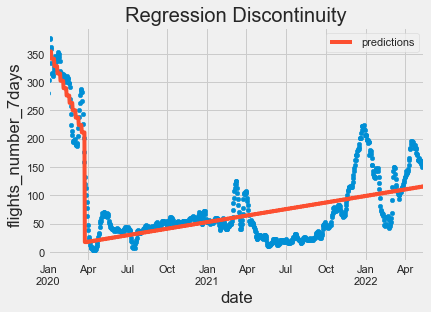

In [161]:
ax = png_fl.plot.scatter(x="date", y="flights_number_7days", color="C0")
png_fl.assign(predictions=model.fittedvalues).plot(
    x="date", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")

#### Teste

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

In [38]:
for country in countries:
    data = psgfl[psgfl.destination_country == country]["flights_number_7days"]
    print(str(country), "'s p-value:", adfuller(data)[1])

Fiji 's p-value: 0.008062727186492386
Kiribati 's p-value: 0.34104573239504854
Marshall Islands (the) 's p-value: 0.05188038531694926
Micronesia (Federated States of) 's p-value: 0.36438194972077903
Nauru 's p-value: 0.02700901941384959
Palau 's p-value: 0.016140047021335695
Papua New Guinea 's p-value: 0.22770131700100477
Samoa 's p-value: 1.8613083000971444e-06
Solomon Islands 's p-value: 0.0027583582591129904
Tonga 's p-value: 3.066324704624645e-13
Tuvalu 's p-value: 0.29642858241913383
Vanuatu 's p-value: 0.1129355278117205


### Granger Causality Test

In [49]:
from statsmodels.tsa.stattools import grangercausalitytests

In [50]:
maxlag = 15
test = 'ssr_chi2test'


def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))),
                      columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(
                data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4)
                        for i in range(maxlag)]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [53]:
df_granger = psgfl[["flights_number_7days", "passengers_number_7days"]]

grangers_causation_matrix(df_granger,
                          variables=df_granger.columns)

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 1
  warnings.warn('covari

,flights_number_7days_x,passengers_number_7days_x
flights_number_7days_y,1.0,0.0
passengers_number_7days_y,0.0,1.0
